# Gridworld


In Reinforcement Learning (RL), a GridWorld is the "Hello World" of environments. It is a discrete, two-dimensional space where an agent moves from cell to cell to maximize its rewards.

It serves as the perfect bridge between theory and practice because every component of a Markov Decision Process (MDP) is visible and countable.

A GridWorld is defined by four core mathematical components:

- States (S): Each cell in the grid (e.g., (x,y) or a flattened index from 0 to 15).

- Actions (A): Usually four discrete moves: Up, Down, Left, and Right.

- Transitions (P): The rules of movement. In a simple grid, this is deterministic (moving 'Right' always lands you in the cell to the right). If you hit a wall, you stay put.

- Rewards (R): The feedback signal.

- Step Penalty: Usually −1 per move to force the agent to find the shortest path.

- Goal: A large positive reward or 0 (with penalties elsewhere).

- Traps: Large negative rewards (e.g., −10) that may end the episode.

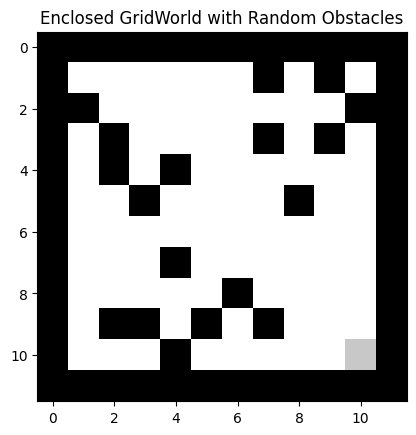

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# clean 255
# goal 200


def generate_enclosed_map(rows=15, cols=15, wall_density=0.2, trap_density=0.):
    # Start with a clean white path (255)
    grid = np.full((rows, cols), 255, dtype=np.uint8)
    
    grid[0, :] = 0   # Top wall
    grid[-1, :] = 0  # Bottom wall
    grid[:, 0] = 0   # Left wall
    grid[:, -1] = 0  # Right wall
    
    interior_shape = (rows-2, cols-2)
    random_roll = np.random.rand(*interior_shape)
    
    interior_mask = np.full((rows, cols), False)
    interior_mask[1:-1, 1:-1] = True
    
    grid[(interior_mask) & (np.pad(random_roll < wall_density, 1, constant_values=False))] = 0
    grid[(interior_mask) & (np.pad(random_roll > 1 - trap_density, 1, constant_values=False))] = 50
    
    grid[-2, -2] = 200    # Bottom-right goal
    
    return grid

rows, cols = 12, 12
grid_bitmap = generate_enclosed_map(rows, cols)
plt.imshow(grid_bitmap, cmap='gray')
plt.title("Enclosed GridWorld with Random Obstacles")
plt.show()

In [35]:
# define rewards
WORLD_CONFIG = {
    0:   {"reward": 0,      "terminal": False, "label": "Wall"},   # Penalty handled by 'stay-put'
    50:  {"reward": -10,    "terminal": True,  "label": "Trap"},   # Big penalty, ends game
    200: {"reward": 10,     "terminal": True,  "label": "Goal"},   # Big prize, ends game
    255: {"reward": -1,     "terminal": False, "label": "Path"}    # Step cost to encourage speed
}

# convert config to two maps like the one we generated 
def parse_grid(grid_bitmap):
    rows, cols = grid_bitmap.shape
    reward_grid = np.zeros((rows, cols))
    terminal_mask = np.zeros((rows, cols), dtype=bool)

    for val, props in WORLD_CONFIG.items():
        # Masking: find all coordinates where the bitmap matches the value
        mask = (grid_bitmap == val)
        reward_grid[mask] = props["reward"]
        terminal_mask[mask] = props["terminal"]
        
    return reward_grid, terminal_mask

reward_grid, terminal_mask = parse_grid(grid_bitmap)

## Montecarlo gridworld

Now we try moving in the world by a random policy

In [ ]:
MOVEMENTS = [(-1, 0), (1, 0), (0, -1), (0,1)]
#               UP  -- DOWN -- LEFT -- RIGHT  

def step(s, action_idx, grid_bitmap, reward_grid, terminal_mask):

    # implement a step
    return s_next, reward, done

def simulate_episode(start_state, grid_bitmap, reward_grid, terminal_mask, policy, gamma=0.9, max_steps=100):

    # Calculate Return G_t = sum of discounted rewards
    # We calculate backwards for efficiency: G = r + gamma * G

    #use the step

    
    # Return starting state and the total discounted return from t=0
    return returns[-1]



In [ ]:
def monte_carlo_evaluation(grid_bitmap, reward_grid, terminal_mask, policy, num_episodes=500):
    # run many episodes for each one of the cells as starting point
    pass

In [40]:
def random_policy(state):
    return np.random.randint(0,4)

V_mc_grid = monte_carlo_evaluation(grid_bitmap, reward_grid, terminal_mask, random_policy, num_episodes=500)

100%|██████████| 144/144 [00:21<00:00,  6.59it/s]


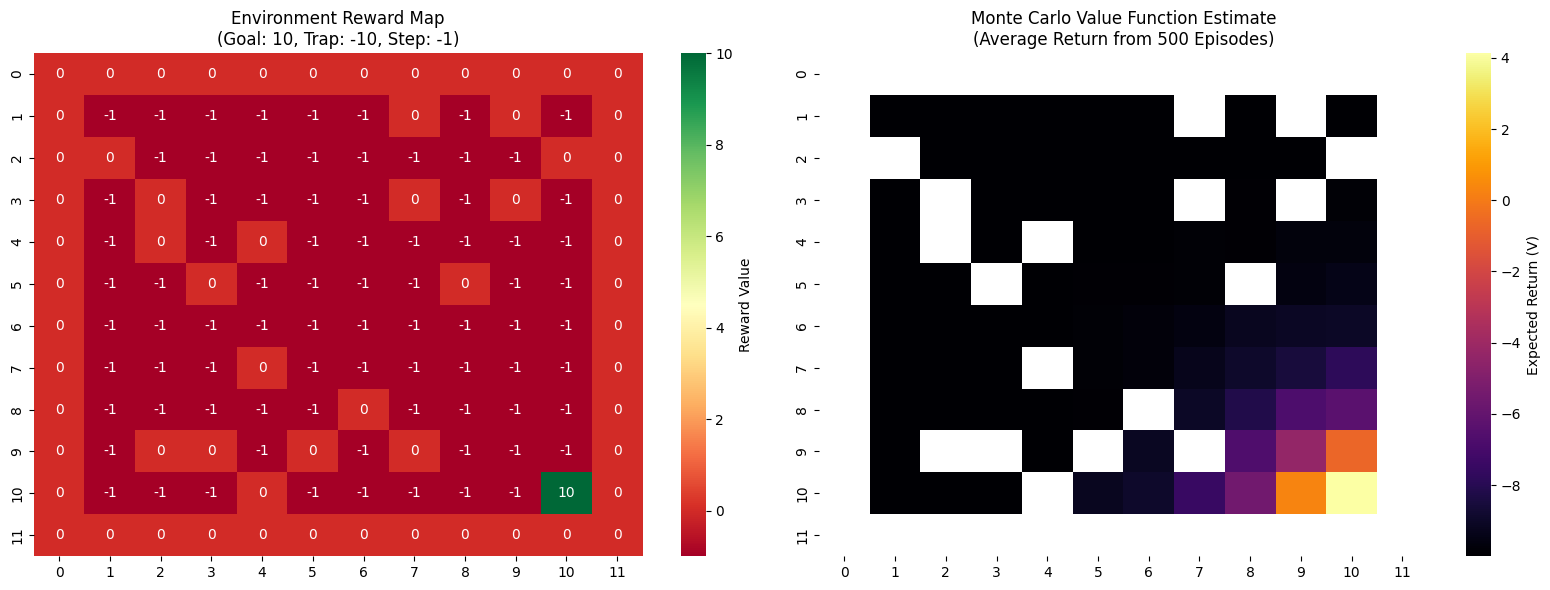

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(reward_grid, annot=True, fmt=".0f", cmap="RdYlGn", ax=ax[0], cbar_kws={'label': 'Reward Value'})
ax[0].set_title("Environment Reward Map\n(Goal: 10, Trap: -10, Step: -1)")

# We mask the walls so they appear empty (Value is irrelevant there)
mask_walls = (grid_bitmap == 0)
sns.heatmap(V_mc_grid, annot=False, cmap="inferno", ax=ax[1], mask=mask_walls, cbar_kws={'label': 'Expected Return (V)'})
ax[1].set_title("Monte Carlo Value Function Estimate\n(Average Return from 500 Episodes)")

plt.tight_layout()
plt.show()

## Solving the problem with the bellman equations

This is the "mathematical engine" of the lab. Since we are using a Fixed Random Policy, the Bellman Equation transitions from a complex optimization problem to a straightforward system of linear equations.1. The Bellman Expectation EquationFor a fixed policy $\pi$, the value of a state $s$ is the expected sum of future discounted rewards. Mathematically, it is expressed as:$$V^{\pi}(s) = \sum_{a \in A} \pi(a|s) \sum_{s' \in S, r \in R} p(s', r|s, a) \left[ r + \gamma V^{\pi}(s') \right]$$


We are using a Uniform Random Policy ($\pi(a|s) = 0.25$) and the environment is Deterministic ($p=1$ for the result of an action), the equation simplifies to:$$V(s) = 0.25 \sum_{a \in \{U,D,L,R\}} \left( \text{Reward}(s, a) + \gamma V(s_{next}) \right)$$ 


To solve this for all $N$ states simultaneously, we rewrite it in matrix-vector form. This turns $16$ (or $100$) individual equations into one single operation:$$\mathbf{V} = \mathbf{R} + \gamma \mathbf{P} \mathbf{V}$$


Where:

- $\mathbf{V}$: An $N \times 1$ vector of values we want to find.

- $\mathbf{R}$: An $N \times 1$ vector of expected rewards for each state under the random policy.

- $\mathbf{P}$: An $N \times N$ Transition Probability Matrix, where $P_{ij}$ is the probability of landing in state $j$ starting from state $i$.

- $\gamma$: The discount factor (e.g., $0.9$). 

P encodes our policy, in this case it is a matrix which has entries 0 for each element unreachable and 0.25 for each element reachable! Second note we can factor out an "expected reward" since we can loop on all the states from there and factor out this R vector (which results from the multipltication $PR^*$ where $R^*$ contains all the rewards)

To find $\mathbf{V}$, we rearrange the equation using linear algebra:Move the $V$ terms to one side: $\mathbf{V} - \gamma \mathbf{P} \mathbf{V} = \mathbf{R}$Factor out $\mathbf{V}$: $(\mathbf{I} - \gamma \mathbf{P}) \mathbf{V} = \mathbf{R}$Solve for $\mathbf{V}$: $\mathbf{V} = (\mathbf{I} - \gamma \mathbf{P})^{-1} \mathbf{R}$ 



In [ ]:
def build_matrices_from_random_policy(grid_bitmap, reward_grid, terminal_mask, gamma=0.9):

    # Initialize P as an N x N matrix and R as an N x 1 vector

        
    # In an MDP, terminal states transition to themselves with prob 1.0
            
            # Use our step logic to find where this action leads
            # dr, dc = [(-1,0), (1,0), (0,-1), (0,1)][a_idx]
            
            # Update Transition Matrix: P[from_state, to_state]
            
            # Update Reward Vector: R[state] is the expected immediate reward
            # R(s) = sum_{a} pi(a|s) * Reward(s, a)
    return P, R_vec



def solve_bellman_analytical(P, R_vec, gamma=0.9):
    """
    Solves (I - gamma*P)V = R
    """
    
    # Solve the linear system Ax = b 
    # where A = (I - gamma*P) and b = R_vec
    
    return V_exact


In [56]:
P, R_vec = build_matrices_from_random_policy(grid_bitmap, reward_grid, terminal_mask )
V_exact = solve_bellman_analytical(P, R_vec, gamma=0.9)

V_exact_grid = V_exact.reshape(rows, cols)

R_expected_grid = R_vec.reshape(rows, cols)

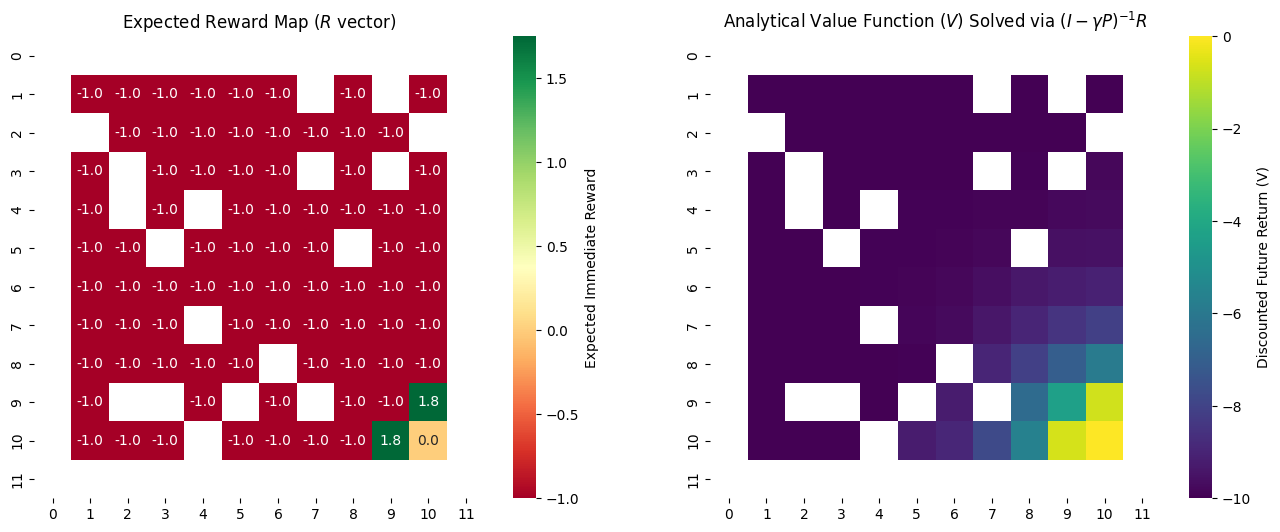

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Define the wall mask
wall_mask = (grid_bitmap == 0)

# --- Plot 1: Expected Rewards (R_vec) ---
sns.heatmap(R_expected_grid, mask=wall_mask, annot=True, fmt=".1f", 
            cmap="RdYlGn", ax=ax[0], cbar_kws={'label': 'Expected Immediate Reward'})
ax[0].set_title(r"Expected Reward Map ($R$ vector)")

# --- Plot 2: Exact Value Function (V) ---
sns.heatmap(V_exact_grid, mask=wall_mask, annot=False, 
            cmap="viridis", ax=ax[1], cbar_kws={'label': 'Discounted Future Return (V)'})
ax[1].set_title(r"Analytical Value Function ($V$) Solved via $(I - \gamma P)^{-1} R$")

plt.show()

## Policy extraction

Now from this V we can extract a greedy policy!

For each state we can use as a policy to move towards the state that maximizes reward.

Then redo the montecarlo step and see what happens to the Value function.

In [96]:
def extract_greedy(V, grid_bitmap, terminal_mask):
    # for each state choose as action the one that maximizes the expected reward
    return policy_vals
policy_vals = extract_greedy(V_exact.reshape(12,12), grid_bitmap, terminal_mask) 


    

Now apply this policy to the montecarlo

In [97]:
def greedy_policy(s):
    return policy_vals[s]

V_mc_greedy = monte_carlo_evaluation(grid_bitmap, reward_grid, terminal_mask, greedy_policy, num_episodes=500)

100%|██████████| 144/144 [00:01<00:00, 131.13it/s]


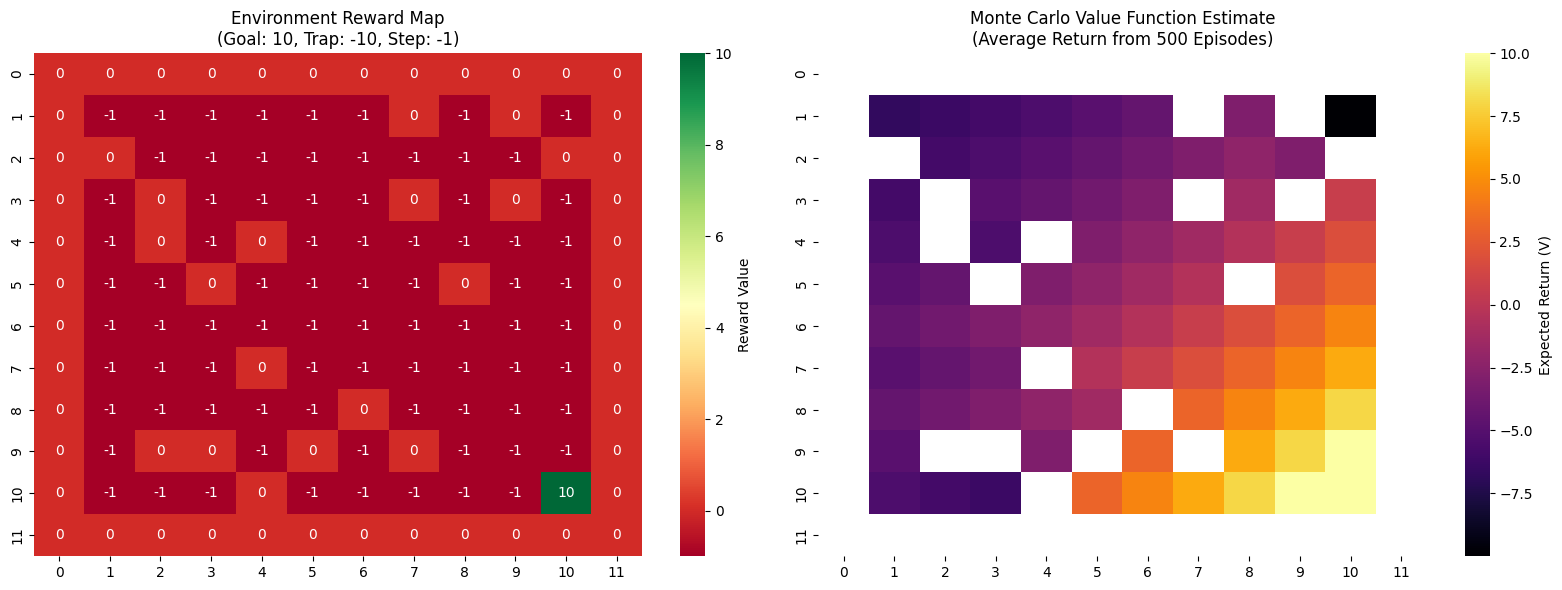

In [98]:
# visualize greedy policy results

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(reward_grid, annot=True, fmt=".0f", cmap="RdYlGn", ax=ax[0], cbar_kws={'label': 'Reward Value'})
ax[0].set_title("Environment Reward Map\n(Goal: 10, Trap: -10, Step: -1)")

# We mask the walls so they appear empty (Value is irrelevant there)
mask_walls = (grid_bitmap == 0)
sns.heatmap(V_mc_greedy, annot=False, cmap="inferno", ax=ax[1], mask=mask_walls, cbar_kws={'label': 'Expected Return (V)'})
ax[1].set_title("Monte Carlo Value Function Estimate\n(Average Return from 500 Episodes)")

plt.tight_layout()
plt.show()

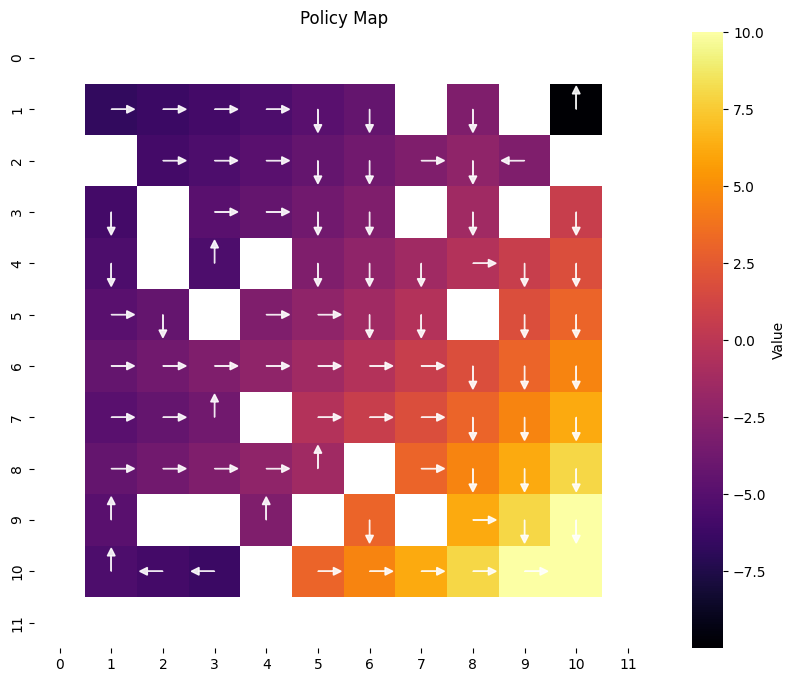

In [99]:
def plot_policy_from_func(V_grid, grid_bitmap, policy_func, title="Policy Map"):
    nrows, ncols = grid_bitmap.shape
    plt.figure(figsize=(10, 8))
    
    # Background Heatmap
    mask_walls = (grid_bitmap == 0)
    sns.heatmap(V_grid, annot=False, cmap='inferno', mask=mask_walls, cbar_kws={'label': 'Value'})
    
    arrows = {0: (0, -0.3), 1: (0, 0.3), 2: (-0.3, 0), 3: (0.3, 0)}
    
    for i in range(nrows):
        for j in range(ncols):
            s = i * ncols + j
            
            # Don't draw arrows on walls or terminal states
            if grid_bitmap[i, j] in [0, 50, 200]:
                continue
                
            # EXECUTE the policy function
            action = policy_func(s)
            
            dx, dy = arrows[action]
            plt.arrow(j + 0.5, i + 0.5, dx, dy, 
                      head_width=0.15, head_length=0.15, 
                      fc='white', ec='white', alpha=0.9)

    plt.title(title)
    plt.show()

plot_policy_from_func(V_mc_greedy, grid_bitmap, greedy_policy)

Note that we can write a simplified form for the Belman equation also in this casem since the policy is not random but it is deterministic.

An additional excercise is to retrieve the exact Value function also in this case using the belman equation.